# import packages

In [ ]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std
from sklearn.model_selection import GridSearchCV

import pickle

from ctgan import CTGANSynthesizer

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict
from sklearn import svm
if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'train_and_vis'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils
import data_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

### Synthetic Data creation
Performed with CTGANSynthesizer

In [ ]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

# Dataset retrieval
Workings of the function is packaged into data_utils (for readability). Data is generated within "process_data.ipynb".

In [2]:
datasets = data_utils.retrieveAllDatasets()

kmer: 3
kmer: 4
kmer: 5
kmer: 6


# TODO

In [ ]:
clf = svm.SVC(kernel='linear', probability=True)
model_utils.getOptimalModels(clf, datasets, kmer_range=[4, 6], onlyNormalized = True)

In [ ]:
dsnames = ['zhang', 'nardus', 'merged']
kmers = [4, 6]
features = ['normalized', 'regular']

for kmer in range(kmers[0], kmers[1]+1):
    for dsname in dsnames:
        for feature in features:
            ds = datasets[dsname][f'{feature}-{kmer}']
            merged = datasets['merged'][f'{feature}-{kmer}']
            
            lrmodel = LogisticRegression(
                multi_class="multinomial", max_iter=1000,
                fit_intercept=False, tol=0.001, solver='saga', random_state=42)
            lrmodel.fit(ds['X_train'], ds['y_train'])
            acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])
            # predictions = lrmodel.predict(datasets['merged']['X_test'])
            # picklething = pickle.load(open('models/curr_models/lrmodel.pkl', 'rb'))
            # print(accuracy_score(merged['y_test'], predictions))
            # print(accuracy_score(merged['y_test'], picklething.predict(merged['X_test'])))
            model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir=f'models/curr_models/kmer{str(kmer)}')


# model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir='models/misc')

In [ ]:
merged = datasets['merged']['normalized-4']

ds = datasets['zhang'][f'normalized-4']

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['nardus'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['zhang'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])


ds = datasets['merged'][f'normalized-4']
merged = datasets['merged'][f'normalized-4']

# print(len(ds['X_train'])+len(ds['X_test']))

lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(ds['X_train'], ds['y_train'])
acc = validation_utils.cross_validate(lrmodel, merged['X_test'], merged['y_test'])

X_test, y_test = ds['X_test'], ds['y_test']
model_utils.saveModel(lrmodel, "lrmodel", X_test, y_test, dir="models/curr_models/kmer4")

### Generate & validate performance of KNN (baseline) on dataset
82.6% accuracy

In [ ]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
print(validation_utils.cross_validate(knntest, X_test, y_test))
model_utils.saveModel(knntest, "knn", X_test, y_test, dir=f"models/curr_models/kmer{kmer}")

In [ ]:
predictions = knntest.predict(X_test)
picklething = pickle.load(open('models/curr_models/kmer4/knn.pkl', 'rb'))
picklescore = validation_utils.cross_validate(picklething, X_test, y_test)
# print(knntest, picklescore)
# saveModel(knntest, "knn", X_test, y_test)

In [20]:
print(picklescore)

0.826


### Evaluate & validate performance of random forest (baseline) on dataset

In [21]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

model_utils.saveModel(randforest, "randforest", X_test, y_test, dir=f"models/curr_models/kmer{kmer}")

does not exist


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [ ]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(validation_utils.cross_validate(randforest, X_test, y_test))

### XGB classifier - was determined to be overfitting too much

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}
xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
)
saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True, dir="models/synthetic_data_testing")


### Grid-Searched version of the Gradient Boosting classifier

In [ ]:
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

"""
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
"""

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

# parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

In [42]:
zhang_GBM = pickle.load(open('models/curr_models/nardus_gridsearch.pkl', 'rb'))
merged_GBM = pickle.load(open('models/test/nardus_gridsearch.pkl', 'rb'))
zhang_knn = pickle.load(open('models/curr_models/knn.pkl', 'rb'))
zhang_randforest = pickle.load(open('models/curr_models/randforest.pkl', 'rb'))
zhang_svm = pickle.load(open('models/curr_models/svm.pkl', 'rb'))
zhang_xgboost = pickle.load(open('models/curr_models/xgBoost.pkl', 'rb'))

models = {
    'zhang_GBM': zhang_GBM.best_estimator_,
    'merged_GBM': merged_GBM.best_estimator_,
    'zhang_knn': zhang_knn,
    'zhang_randforest': zhang_randforest,
    'zhang_svm': zhang_svm,
    'zhang_xgboost': zhang_xgboost
}

### Validate models on the merged dataset

In [43]:
# order: mergedGBM, zhangGBM, zhangknn, zhangrandforest
scores_merged, scores_nardus, scores_zhang = [], [], []

In [44]:
ds = datasets['merged'][f'normalized-{kmer}']

# this one is trained on only the nardus one

"""
{'learning_rate': 0.15, 'max_depth': 8, 'max_features': 3, 'min_samples_split': 30, 'n_estimators': 130, 'subsample': 0.8}
"""
X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

for modelName in models:
    print(modelName)
    scores_merged.append(validation_utils.cross_validate(models[modelName], X_test, y_test))

zhang_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.920 (0.014)
tn: 1877, fp: 5, fn: 33, tp: 321
merged_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.918 (0.015)
tn: 1864, fp: 18, fn: 113, tp: 241
zhang_knn
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


Accuracy: 0.825 (0.024)
tn: 1499, fp: 383, fn: 319, tp: 35
zhang_randforest
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.869 (0.020)
tn: 1864, fp: 18, fn: 354, tp: 0
zhang_svm
SVC


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Accuracy: 0.897 (0.015)
tn: 1875, fp: 7, fn: 354, tp: 0
zhang_xgboost
XGBClassifier
xgboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.921 (0.015)
tn: 1872, fp: 10, fn: 72, tp: 282


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.4s finished


In [45]:
print(scores_merged)

[0.92, 0.918, 0.825, 0.869, 0.897, 0.921]


### Validate models on only zhang dataset

In [46]:
# only zhang new
# parameters={
#    'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
# }
# onlyzhanggradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
#     learning_rate=0.3, max_features=parameters['max_features'], 
#     max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
#     min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
# )

# onlyzhanggradBoost.fit(X_train, y_train)
# print(validation_utils.cross_validate(onlyzhanggradBoost, X_test, y_test))

ds = datasets['zhang'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
for modelName in models:
    print(modelName)
    scores_zhang.append(validation_utils.cross_validate(models[modelName], X_test, y_test))

zhang_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.945 (0.015)
tn: 1616, fp: 2, fn: 15, tp: 233
merged_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.947 (0.015)
tn: 1616, fp: 2, fn: 33, tp: 215
zhang_knn
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Accuracy: 0.869 (0.024)
tn: 1259, fp: 359, fn: 228, tp: 20
zhang_randforest
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.902 (0.021)
tn: 1600, fp: 18, fn: 248, tp: 0
zhang_svm
SVC


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished


Accuracy: 0.931 (0.018)
tn: 1614, fp: 4, fn: 248, tp: 0
zhang_xgboost
XGBClassifier
xgboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.946 (0.013)
tn: 1617, fp: 1, fn: 13, tp: 235


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished


In [47]:
print(scores_zhang)

[0.945, 0.947, 0.869, 0.902, 0.931, 0.946]


### Validate models only on nardus dataset

In [48]:
ds = datasets['nardus'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
print("acc on nardus")
print("merged")

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

onlynardgradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

onlynardgradBoost.fit(X_train, y_train)


acc on nardus
merged
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV 2/5; 1/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 1/5; 1/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 5/5; 1/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 3/5; 1/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 4/5; 1/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 1/5; 2/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 2/5; 2/972] START learning_rate=0.1, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 3/5; 2/972] START learning_rate=0.1, max_

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features=2,
                                                  n_estimators=120,
                                                  random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': range(6, 9), 'max_features': range(2, 5),
                         'min_samples_split': range(10, 40, 10),
                         'n_estimators': range(100, 140, 10),
                         'subsample': [0.8, 0.85, 0.9]},
             scoring='roc_auc', verbose=10)

GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.759 (0.029)
tn: 269, fp: 11, fn: 77, tp: 13
0.759
GradientBoostingClassifier
gradboost
Accuracy: 0.752 (0.033)
tn: 276, fp: 4, fn: 7, tp: 83
0.752
GridSearchCV
precision recall: 0.9827915314299951
roc: 0.994920634920635


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


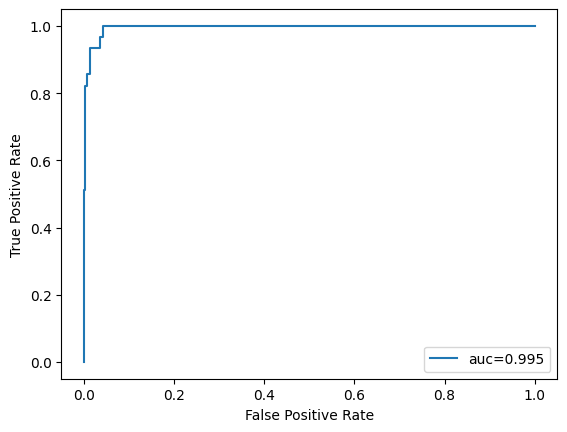

[9.30483839e-01 5.57846026e-03 2.81566008e-02 2.73996028e-03
 3.60250269e-02 3.44646486e-02 8.76468189e-01 9.60416627e-01
 6.56687374e-03 1.35732174e-02 9.14009691e-01 7.88635210e-03
 2.60727962e-03 5.97873192e-03 1.73838988e-02 4.58784235e-03
 1.43523983e-03 2.50638670e-03 8.99243192e-01 1.46480670e-02
 4.45124210e-03 1.71677469e-01 8.44962083e-03 1.54862823e-02
 1.43329968e-02 3.63292316e-03 3.41932220e-02 5.85794027e-03
 8.77485981e-01 7.19318849e-02 9.64302534e-01 9.37464357e-01
 2.72957839e-03 1.16271307e-01 6.85466723e-03 2.87099746e-02
 2.58487201e-02 4.14097750e-01 3.05306391e-02 1.79029096e-02
 7.97523129e-03 8.25738142e-01 9.70315305e-01 4.46847942e-02
 2.03699744e-02 4.15882350e-03 2.28174980e-02 2.36234108e-02
 9.29439151e-01 7.73829366e-03 4.67215580e-03 2.05357098e-02
 1.85057372e-03 1.62648070e-03 1.43309763e-03 3.78431442e-03
 9.79621237e-01 5.01718156e-03 5.82796793e-02 6.87455098e-02
 1.72904012e-02 3.52909023e-02 9.20054600e-03 1.43712505e-02
 9.30399259e-01 8.181768

In [55]:
ds = datasets['nardus'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

print(validation_utils.cross_validate(onlynardgradBoost.best_estimator_, X_test, y_test))
print(validation_utils.cross_validate(merged_GBM.best_estimator_, X_test, y_test))

print(validation_utils.draw_roc_curve(merged_GBM, X_test, y_test))

In [ ]:
ds = datasets['nardus'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

for modelName in models:
    print(modelName)
    scores_zhang.append(validation_utils.cross_validate(models[modelName], X_test, y_test))